In [23]:
import hashlib  
import os 
import tarfile  
import zipfile  
import requests
%matplotlib inline  
import numpy as np  
import pandas as pd  
import torch  
from torch import nn  
import sys
sys.path.append('F:/AirCAS/RS_code/deeplearning_LiMu/Learn_yss') 
import utils as d2l

## 一、加载数据

In [26]:
#@save  
DATA_HUB = dict()  
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['kaggle_house_train'] = ( #@save  
    DATA_URL + 'kaggle_house_pred_train.csv',  '585e9cc93e70b39160e7921475f9bcd7d31219ce')  
DATA_HUB['kaggle_house_test'] = ( #@save  
    DATA_URL + 'kaggle_house_pred_test.csv',  'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
train_data = pd.read_csv( d2l.download('kaggle_house_train'))  
test_data = pd.read_csv( d2l.download('kaggle_house_test'))

In [28]:
print(train_data.shape)  
print(test_data.shape)

(1460, 81)
(1459, 80)


训练数据集包括1460个样本,每个样本80个特征和1个标签,而测试数据集包含1459个样本,每个样本80个特征。

## 二、数据预处理

1.将第一列（ID）删掉，同时取出所有特征

In [33]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [35]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [44]:
# 若无法获得测试数据,则可根据训练数据计算均值和标准差  
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  
all_features[numeric_features] = all_features[numeric_features].apply(  
    lambda x: (x - x.mean()) / (x.std())) 
# 在标准化数据之后,所有均值消失,因此我们可以将缺失值设置为0  
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理离散值,包括诸如“MSZoning”之类的特征,用独热编码替换它们

In [47]:
# “Dummy_na=True”将“na”(缺失值)视为有效的特征值,并为其创建指示符特征  
all_features = pd.get_dummies(all_features, dummy_na=True)  
all_features


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.202033,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.525112,0.580807,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0
1,-0.873466,0.501785,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.572152,1.177910,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0
2,0.067320,-0.061269,0.137173,0.646073,-0.507197,0.980053,0.848819,0.334770,0.097856,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0
3,0.302516,-0.436639,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.572152,-0.494856,-0.29308,...,-0.049021,0.394951,-0.018509,3.789226,-0.064238,-0.091035,-0.126513,-2.155097,-0.302641,0.0
4,0.067320,0.689469,0.518814,1.355319,-0.507197,0.947040,0.753100,1.387248,0.468851,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.266564,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.572152,-0.969026,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0
1455,2.419286,-2.266564,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.572152,-0.415828,-0.29308,...,-0.049021,0.394951,-0.018509,3.789226,-0.064238,-0.091035,-0.126513,-2.155097,-0.302641,0.0
1456,-0.873466,4.255477,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.572152,1.717937,-0.29308,...,-0.049021,0.394951,-0.018509,3.789226,-0.064238,-0.091035,-0.126513,-2.155097,-0.302641,0.0
1457,0.655311,-0.342796,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.572152,-0.229233,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0


转化成张量

In [49]:
n_train = train_data.shape[0]  
print(n_train)
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)  
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)  
train_labels = torch.tensor(  
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

1460


## 三、训练

以线性模型作为baseline，MESLoss作为损失函数

In [170]:
loss = nn.MSELoss()  
in_features = train_features.shape[1]
print(in_features)
def get_net():  
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

330


使用预测价格的对数和真实标签价格的对数之差作为损失函数

In [173]:
def log_rmse(net, features, labels):  
    # 为了在取对数时进一步稳定该值,将小于1的值设置为1 
    clipped_preds = torch.clamp(net(features), 1, float('inf'))  
    rmse = torch.sqrt(loss(torch.log(clipped_preds), 
                           torch.log(labels)))  
    return rmse.item()

In [175]:
def log_rmse_1(pred, labels):  
    # 为了在取对数时进一步稳定该值,将小于1的值设置为1
    loss = nn.MSELoss() 
    clipped_preds = torch.clamp(pred, 1, float('inf'))  
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))  
    return rmse

In [177]:
#训练模型 目的是记录训练误差与验证集误差
def trainer(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            #l=log_rmse_1(net(X), y)
            l = loss(net(X), y)## 有个疑问？？这里为什么不用log_rmse,
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        #train_ls.append(log_rmse_1(net(train_features), train_labels).detach().numpy())
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
            #test_ls.append(log_rmse_1(net(test_features), test_labels).detach().numpy())

    
    return train_ls, test_ls

K-折交叉验证

In [180]:
#K折数据集转化函数 这个函数的作用是在进行 k 折交叉验证时，帮助你将数据分割成训练集和验证集
def get_k_fold_data(k, i, X, y):
    """它选择第i个切片作为验证数据,其余  部分作为训练数据。"""
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


In [182]:
#K折交叉验证 
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = trainer(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            # 只绘制了第一折训练
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 四、调参

折1，训练log rmse8.581845, 验证log rmse8.546182
折2，训练log rmse8.444959, 验证log rmse8.709670
折3，训练log rmse8.535181, 验证log rmse8.692069
折4，训练log rmse8.548470, 验证log rmse8.698904
折5，训练log rmse8.536894, 验证log rmse8.720692
5-折验证: 平均训练log rmse: 8.529470, 平均验证log rmse: 8.673503


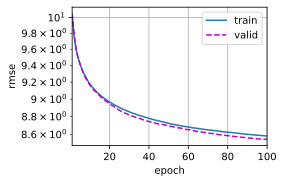

In [185]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.1, 1, 32
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,  weight_decay, batch_size)  
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '  f'平均验证log rmse: {float(valid_l):f}')

In [109]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = trainer(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：8.631944


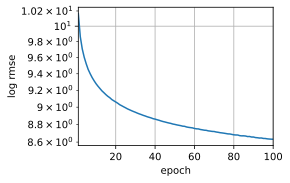

In [110]:
train_and_pred(train_features, test_features, train_labels, test_data,  num_epochs, lr, weight_decay, batch_size)